<a href="https://colab.research.google.com/github/SaiSriDatta/Python-work/blob/main/Implied_Volatility_Trading_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The intution is to trade based on Implied volatility. If the VIX goes up even though the markets are going up, we short S&P500 for two days and go long VIX.
#Risk free rate and transaction costs are not considered.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import warnings
warnings.filterwarnings("ignore")


In [45]:
#making a file in to load and save data
def load_data(symbol):

  direc = 'data//'
  os.makedirs(direc,exist_ok =True)
  file_name = os.path.join(direc, symbol + '.csv')

  if not os.path.exists(file_name):
    ticker = yf.Ticker(symbol)
    df = ticker.history(start = "2000-01-02", end = "2024-5-31")
    df.to_csv(file_name)



  df = pd.read_csv(file_name, index_col = 0)
  df.index = pd.to_datetime(df.index,utc=True).date
  return df




In [46]:
#using snp500 and IndiaVIX for volatility
snp500= load_data("^GSPC")
vix= load_data("^VIX")

In [47]:
#finding the rolling sum of the daily returns of snp500
#percent change
snp500["daily_return"]=snp500["Close"].pct_change()
snp500["daily_return_direction"]=np.nan
snp500.loc[snp500["daily_return"]>0,"daily_return_direction"]=1
snp500.loc[snp500["daily_return"]<0,"daily_return_direction"]=-1
snp500["rolling_sum"]=snp500["daily_return_direction"].rolling(window=2).sum()


In [48]:
#doing the same for vix
vix["daily_return"]=vix["Close"].pct_change()
vix["daily_return_direction"]=np.nan
vix.loc[vix["daily_return"]>0,"daily_return_direction"]=1
vix.loc[vix["daily_return"]<0,"daily_return_direction"]=-1
vix["rolling_sum"]=vix["daily_return_direction"].rolling(window=2).sum()

In [49]:
#Combining the two rolling sums
data = pd.concat([snp500[["daily_return","rolling_sum"]],vix[["daily_return","rolling_sum"]]],axis=1)
data.columns=["snp500_daily_return","snp500_rolling_sum","vix_daily_return","vix_rolling_sum"]
data['Total_rolling_sum'] = data['snp500_rolling_sum'] + data['vix_rolling_sum']


In [50]:
#Creating a signal
data["signal"]=0
data.loc[data["Total_rolling_sum"]!=4.0,'signal']=0
data.loc[data["Total_rolling_sum"]==4.0,'signal']=1
print("Count of Trades:",len(data[data["signal"]==1]))

Count of Trades: 67


In [51]:
#Signal is short first two days
data["signal"]=-data["signal"].shift(1) -data["signal"].shift(2)+data["signal"].shift(3)+data["signal"].shift(4)
data["signal"]=data["signal"].fillna(0)

data['strategy_return'] = (data['signal'] * data["snp500_daily_return"] - data['signal'] * data["vix_daily_return"])


In [52]:
#Calculating Sharpe
snp_sharpe = data["snp500_daily_return"].mean() / data["snp500_daily_return"].std()*np.sqrt(252)
print(f"S&P500 Sharpe Ratio: {snp_sharpe:.2f}")

strategy_sharpe = data["strategy_return"].mean() / data["strategy_return"].std()*np.sqrt(252)
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.2f}")

cumstrat = data['strategy_return'].cumsum()
cumsum = data['snp500_daily_return'].cumsum()


S&P500 Sharpe Ratio: 0.37
Strategy Sharpe Ratio: 0.28


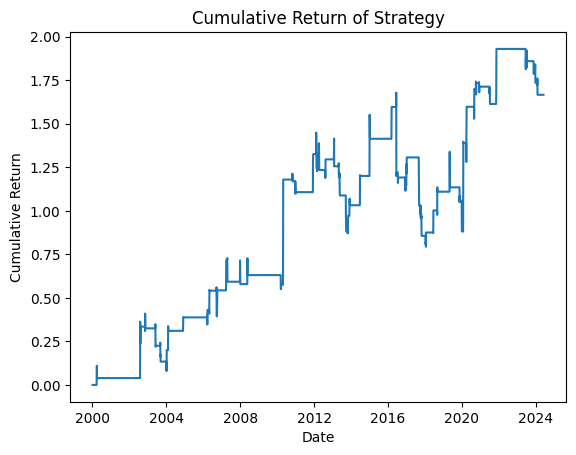

Cumulative return of Strategy: 1.6661464355528153
Cumulative return of S&P 500: 1.744977704090278


In [53]:
plt.plot(cumstrat)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Strategy')
plt.show()
print(f"Cumulative return of Strategy: {cumstrat[-1]}")
print(f"Cumulative return of S&P 500: {cumsum[-1]}")

In [ ]:
##The strategy seems to give lesser returns than S&P returns while backtesting.